## COMP41680 Assignment 2
## Diarmuid Finnan - 13362201

In [1]:
import bs4
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Data retrieval function

Opens input link and returns parsed html

In [2]:
# The base link
master_link = "http://mlg.ucd.ie/modules/COMP41680/archive/"
link_INDEX = master_link+"index.html"

# Function to open input link and parse html
def openlink(link):
    try:
        response = requests.get(link)

    except response.status_code as e:
        print(e.reason)
        print("Error getting data from URL. Check link")

    else:
        html = response.text
        return html
    
#openlink(link_INDEX)

### "Homepage"

Get html and save links to month pages

In [3]:
index = openlink(link_INDEX)

# Parse index page to access tags
index_par = bs4.BeautifulSoup(index,"html.parser")
month_link_arr = []

# Only search the main to not get other links in page
index_par_m = index_par.find("div",class_="main")

# Get links to Month pages
for link in index_par_m.find_all('a'):
    month_link = link.get('href')
    month_link_arr.append(month_link)

### Article and Category retrieval

Open month links, save article category label and article link

Then open article and save only the article body text

In [4]:
# Cycle through months

article_cat = []
article_title = []

error_counter = 0

for i in range(len(month_link_arr)):
    try:
    
        month_page = openlink(master_link+month_link_arr[i])

        # Parse month page 
        month_par = bs4.BeautifulSoup(month_page,"html.parser")
        # Only search the main to not get other links in page
        month_par_m = month_par.find("div",class_="main")

        article_link_arr = []

        # Get document tags, article titles and links
        # Get article category, save to array
        for link in month_par_m.findAll("td",class_="category"):
            text = link.get_text()
            article_cat.append(text)

        # Get article link
        for link in month_par_m.findAll('a'):
            article_link = link.get('href')
            article_link_arr.append(article_link)

            
        for j in range(len(article_link_arr)):
            article = openlink(master_link+article_link_arr[j])
            article_par = bs4.BeautifulSoup(article,"html.parser")
            # Only search the main to not get other links in page
            article_par_m = article_par.find("div",class_="main")

            the_text = []
            
            # Get article content
            # specify class_=None to remove text footer
            for elem in article_par_m.findAll("p",class_=None):
                text = elem.get_text()
                the_text.append(text)
            
            # Remove empty lines
            the_text_check = str(" ").join(list(filter(None,the_text)))

            # Save articles
            f = open("New_Articles/"+str(i+1)+"_"+str(j+1)+".txt",'w',encoding="utf-8")
            f.write(the_text_check)
            f.close()
            
    except Exception as e:
        print(e)
        
        error_counter += 1
        continue

### Remove blank entries and save articles in text file

The loop above only searched for entries with links so there are no blank article entries.

The save loop below checks if the category is N/A doesn't save those that are

In [7]:
# freeze this to call it later in the notebook
cat_filename = "Categories.txt"
counter = 0 

f = open(cat_filename,'w')
for val in article_cat:
    # Remove thing at start
    just_cat = val[1:]
    if just_cat != "N/A":
        counter += 1
        f.write(val+"\n")
f.close()

#### A check for errors in retrieving data


In [9]:
print("Categories:",counter)
print(error_counter)

Categories: 1408
0


### Open saved article files

Cycles through filenames openning and saving content

It will open the file "i_j.txt" and then try i_j+1.txt"

When this fails (it has reached the highest j in i = last article in the month), it will move onto the next month (i + 1)

(Would much prefer to use glob library for accessing files)

In [10]:
# The files start at 1_1
i = 1
j = 1


article_arr = []

# There is no more than 130 articles in any month 
while j < 130:
    try:
        article = open("New_Articles/"+str(i)+"_"+str(j)+".txt",'r',encoding="utf8")
        thetext = article.read()
        
        article_arr.append(thetext)
        j += 1
         

    except Exception as e:
        # Check how far the loop got
        print("Well something happened",i,j)
        print(e)
        try:
            # Error could mean it got to the end of the month
            # Increment i and restart j
            i += 1
            j = 1
            # After 12 its done
            if i == 13:
                print("Out of months!")
                break
            
        # If there's an actual error          
        except Exception as e:
            print("Something Else")
            print(e)
            break

Well something happened 1 119
[Errno 2] No such file or directory: 'New_Articles/1_119.txt'
Well something happened 2 123
[Errno 2] No such file or directory: 'New_Articles/2_123.txt'
Well something happened 3 117
[Errno 2] No such file or directory: 'New_Articles/3_117.txt'
Well something happened 4 118
[Errno 2] No such file or directory: 'New_Articles/4_118.txt'
Well something happened 5 115
[Errno 2] No such file or directory: 'New_Articles/5_115.txt'
Well something happened 6 115
[Errno 2] No such file or directory: 'New_Articles/6_115.txt'
Well something happened 7 123
[Errno 2] No such file or directory: 'New_Articles/7_123.txt'
Well something happened 8 117
[Errno 2] No such file or directory: 'New_Articles/8_117.txt'
Well something happened 9 113
[Errno 2] No such file or directory: 'New_Articles/9_113.txt'
Well something happened 10 123
[Errno 2] No such file or directory: 'New_Articles/10_123.txt'
Well something happened 11 122
[Errno 2] No such file or directory: 'New_Artic

### Open the categories file and save the entries


In [11]:
categories_file = open(cat_filename,'r')
categories = categories_file.read().split("\n")

# The final "\n" makes a final blank line
# remove this
categories = categories[:-1]

#### Double check I have the right amount of the articles and categories

In [12]:
print(len(article_arr))
print(len(categories))

1408
1408


### Text preprocessing


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Maybe change min doc count
vectorizer = TfidfVectorizer(stop_words="english",min_df=5)

tokenize = CountVectorizer().build_tokenizer()

stemmer = PorterStemmer()

lemmatizer = WordNetLemmatizer()

for i in range(len(article_arr)):
    # Tokenize words to process
    words = tokenize(article_arr[i])
    # Stem contents
    words = [w.replace(w,stemmer.stem(w)) for w in words]
    # Put words back to be one string
    words = " ".join(words)
    # Replace in array
    article_arr[i] = words
    

X = vectorizer.fit_transform(article_arr)

terms = vectorizer.get_feature_names()
vocab = vectorizer.vocabulary_

print(len(terms))

4958


#### Add data to pandas Dataframe

In [14]:
df = pd.DataFrame({"Categories":categories,"Article":article_arr})

# Classification

## KNN

This should take in the articles (a list where each entry is an articles as a single string) and the categories. It splits it into data and target, test and training sets. Create a document term matrix of the training data and create a model based on the matrix and the corresponding training targets. It should then create a document term matrix of the test data and use the model created to classify and compare it to the actual category.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

target = np.array(df["Categories"])
data = np.array(df["Article"])
# target = np.array(categories)
# data = np.array(article_arr)

data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.4)


vectorizer = TfidfVectorizer()
train_X = vectorizer.fit_transform(data_train)

print("Training set has %d examples" % data_train.shape[0])
print("Test set has %d examples" % data_test.shape[0])


model = KNeighborsClassifier(n_neighbors=3)
model.fit(train_X, target_train)
print(model)

test_X = vectorizer.transform(data_test)

predicted = model.predict(test_X)

num_sport = (predicted == "\xa0sport").sum()
num_bus = (predicted == "\xa0business").sum()
num_tech = (predicted == "\xa0technology").sum()
print("Number of sport results =",num_sport)
print("Number of business results =",num_bus)
print("Number of technology results",num_tech)

Training set has 844 examples
Test set has 564 examples
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
Number of sport results = 223
Number of business results = 179
Number of technology results 162


In [16]:
from sklearn.metrics import accuracy_score
how_good = accuracy_score(target_test, predicted)
print("Sklearn accuracy score = {}".format(how_good))

# Which is just
total_size = len(predicted)
matching = sum(target_test == predicted)
print("This is just a sanity check for myself",matching/total_size)

Sklearn accuracy score = 0.9592198581560284
This is just a sanity check for myself 0.959219858156


In [17]:
from sklearn.model_selection import cross_val_score

cross_val_X = vectorizer.fit_transform(data)

scores = cross_val_score(model, cross_val_X, target, cv=5,scoring="accuracy")
overall_score = scores.mean()
print(overall_score)

0.955954588742


In [18]:
def run_prediction(kvalue):
    target = np.array(categories)
    data = np.array(article_arr)

    data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.4)


    vectorizer = TfidfVectorizer()
    train_X = vectorizer.fit_transform(data_train)

    model = KNeighborsClassifier(n_neighbors=kvalue)
    model.fit(train_X, target_train)
    
    cross_val_X = vectorizer.fit_transform(data)

    scores = cross_val_score(model, cross_val_X, target, cv=5,scoring="accuracy")
    overall_score = scores.mean()
    #print(overall_score)
    return float(overall_score)

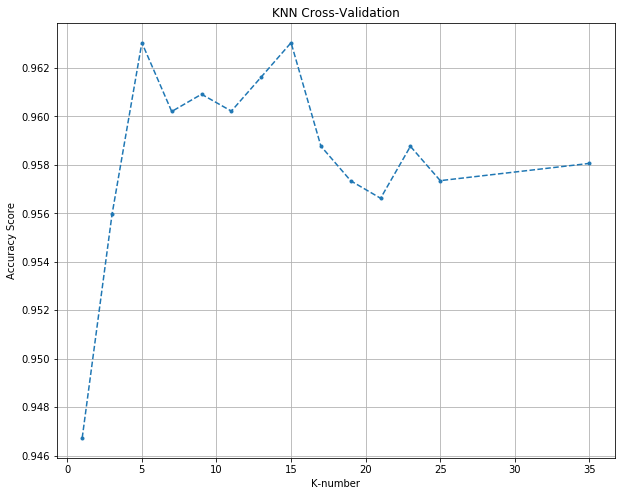

In [19]:
k = [1,3,5,7,9,11,13,15,17,19,21,23,25,35]


accuracy = []


for val in k:
    score = run_prediction(val)
    accuracy.append(score)

plt.figure(figsize=(10,8))
plt.plot(k,accuracy,'.--')
plt.title("KNN Cross-Validation")
plt.xlabel("K-number")
plt.ylabel("Accuracy Score")
plt.grid(True)
plt.show()

### Naive Bayes

In [20]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(train_X, target_train)
predicted = model.predict(test_X)
print(len(predicted))
print(accuracy_score(target_test,predicted))

564
0.989361702128


In [21]:
cross_val_X = vectorizer.fit_transform(data)

scores = cross_val_score(model, cross_val_X, target, cv=5,scoring="accuracy")
overall_score = scores.mean()
print(overall_score)

0.968735902962


### Conclusion
Both the KNN and Naive Bayes method do a very good job (>95% success in almost all cases) at classifying the articles. For the values trialled the k = 5 and k = 15 returned the most accurate results. 

The Naive Bayes performed better than the KNN model even in the cross validation. In this type of system it seems to be a much better predictor.